# Data Preparation of DR16Q Superset Catalogue

> The superset contains 1,440,615 observations of
> quasars, stars, and galaxies that were all targeted as
> quasars (or appeared in previous quasar catalogs).

In [1]:
from astropy.io import fits
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from spectres import spectres

In [2]:
with fits.open("data/DR16Q_Superset_v3.fits") as hdul:
    data = hdul[1].data.byteswap().newbyteorder().copy()
    dataset = pd.DataFrame()
    for col in ["PLATE", "MJD", "FIBERID", "Z_QN", "Z_10K", "Z_CONF_10K", "Z_VI", "Z_CONF", "Z", "SOURCE_Z", "Z_PIPE", "ZWARNING", "Z_PCA", "ZWARN_PCA", "CLASS_PERSON", "Z_CONF"]:
        dataset[col] = data[col]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440615 entries, 0 to 1440614
Data columns (total 15 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   PLATE         1440615 non-null  int32  
 1   MJD           1440615 non-null  int32  
 2   FIBERID       1440615 non-null  int16  
 3   Z_QN          1440615 non-null  float64
 4   Z_10K         1440615 non-null  float64
 5   Z_CONF_10K    1440615 non-null  int16  
 6   Z_VI          1440615 non-null  float64
 7   Z_CONF        1440615 non-null  int16  
 8   Z             1440615 non-null  float64
 9   SOURCE_Z      1440615 non-null  object 
 10  Z_PIPE        1440615 non-null  float64
 11  ZWARNING      1440615 non-null  int32  
 12  Z_PCA         1440615 non-null  float64
 13  ZWARN_PCA     1440615 non-null  int64  
 14  CLASS_PERSON  1440615 non-null  int16  
dtypes: float64(6), int16(4), int32(3), int64(1), object(1)
memory usage: 115.4+ MB


> For objects that have a redshift in the columns `Z_VI` or `Z_10K` and a confidence (`Z_CONF` or `Z_CONF_10K`) of ≥ 2,
> `Z` records the corresponding redshift and `SOURCE_Z` is set to `VI`. Otherwise, if an object has a redshift in the
> columns `Z_DR6Q_HW` or `Z_DR7Q_SCH` these values are used (with `Z_DR6Q_HW` overriding `Z_DR7Q_SCH`) and `SOURCE_Z` is
> set to `DR6Q_HW` or `DR7QV_SCH`. As the `ZDR7Q_HW` redshifts did not formally appear in the Shen et al. (2011) paper,
> these values are not used to populate the `Z` column.
> If no other visual inspection redshift is populated then `Z_DR12Q` is used (and `SOURCE_Z` is set to `DR12QV`).
> For objects with DR12Q redshifts, only the visual inspection redshifts are recorded; DR12Q pipeline redshifts
> are not included. In the absence of any of these visual
> inspection redshifts, `Z` is populated with the automated pipeline redshift (and `SOURCE_Z` is set to `PIPE`).

In [3]:
source_idx = dataset["SOURCE_Z"] != "PIPE"
gt_zero_idx = dataset["Z"] > 0
eq_zero_idx = dataset["Z"] == 0
source_idx.sum(), gt_zero_idx.sum(), eq_zero_idx.sum()

(541608, 1234103, 1)

In [4]:
dataset = dataset[source_idx & (gt_zero_idx | eq_zero_idx)]
dataset.head()

,PLATE,MJD,FIBERID,Z_QN,Z_10K,Z_CONF_10K,Z_VI,Z_CONF,Z,SOURCE_Z,Z_PIPE,ZWARNING,Z_PCA,ZWARN_PCA,CLASS_PERSON
15,6173,56238,528,2.311340,-1.0,-1,2.309,3,2.309,VI,2.308180,0,2.309822,0,3
16,7596,56945,162,2.309355,-1.0,-1,2.309,3,2.309,VI,2.307397,0,2.304973,0,3
19,4216,55477,310,-1.000000,-1.0,-1,0.250,3,0.250,VI,0.249938,0,0.249966,0,3
27,6172,56269,366,2.498696,-1.0,-1,2.497,3,2.497,VI,2.499653,0,2.495232,0,3
28,6177,56268,595,2.511271,-1.0,-1,2.497,3,2.497,VI,2.497960,0,2.495101,0,3


In [5]:
dataset["CLASS_PERSON"].value_counts()

3     394254
0      76513
30     39501
4      30668
1        255
50         1
Name: CLASS_PERSON, dtype: int64

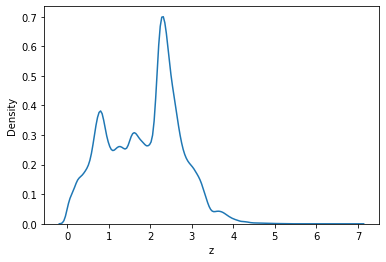

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel("z")
ax.set_ylabel("Density")
sns.kdeplot(data=dataset, x="Z", ax=ax);

## Wavelength Range

In [7]:
with fits.open("data/specObj-dr16.fits") as hdul:
    data = hdul[1].data.byteswap().newbyteorder().copy()
    specobj = pd.DataFrame()
    for col in ["PLATE", "MJD", "FIBERID", "WAVEMIN", "WAVEMAX"]:
        specobj[col] = data[col]
specobj.head()

,PLATE,MJD,FIBERID,WAVEMIN,WAVEMAX
0,266,51602,1,3806.273682,9202.376953
1,266,51602,2,3806.273682,9202.376953
2,266,51602,3,3806.273682,9202.376953
3,266,51602,4,3806.273682,9202.376953
4,266,51602,5,3805.397217,9202.376953


In [8]:
dataset = pd.merge(dataset, specobj, on=["PLATE", "MJD", "FIBERID"], how="left")
dataset.head()

,PLATE,MJD,FIBERID,Z_QN,Z_10K,Z_CONF_10K,Z_VI,Z_CONF,Z,SOURCE_Z,Z_PIPE,ZWARNING,Z_PCA,ZWARN_PCA,CLASS_PERSON,WAVEMIN,WAVEMAX
0,6173,56238,528,2.311340,-1.0,-1,2.309,3,2.309,VI,2.308180,0,2.309822,0,3,3603.296387,10360.959961
1,7596,56945,162,2.309355,-1.0,-1,2.309,3,2.309,VI,2.307397,0,2.304973,0,3,3601.637451,10341.891602
2,4216,55477,310,-1.000000,-1.0,-1,0.250,3,0.250,VI,0.249938,0,0.249966,0,3,3601.637451,10299.117188
3,6172,56269,366,2.498696,-1.0,-1,2.497,3,2.497,VI,2.499653,0,2.495232,0,3,3601.637451,10339.510742
4,6177,56268,595,2.511271,-1.0,-1,2.497,3,2.497,VI,2.497960,0,2.495101,0,3,3605.786377,10363.345703


In [9]:
dataset[["WAVEMIN", "WAVEMAX"]].describe()

,WAVEMIN,WAVEMAX
count,541150.000000,541150.000000
mean,3631.854980,10189.990234
std,73.104118,399.720306
min,3601.637451,5727.960449
25%,3601.637451,10327.614258
50%,3601.637451,10341.891602
75%,3608.278076,10360.959961
max,8986.695312,10396.807617


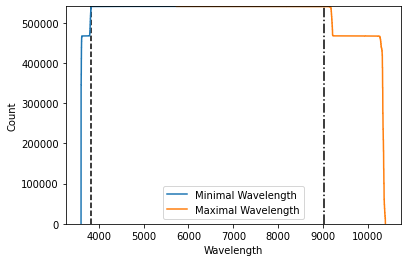

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength")
ax.set_ylabel("Count")
lammin = dataset["WAVEMIN"].quantile(0.999)
lammax = dataset["WAVEMAX"].quantile(0.001)
ax.axvline(lammin, color="k", linestyle="--")
ax.axvline(lammax, color="k", linestyle="-.")
sns.ecdfplot(data=dataset, x="WAVEMIN", stat="count", label="Minimal Wavelength", ax=ax)
sns.ecdfplot(data=dataset, x="WAVEMAX", stat="count", label="Maximal Wavelength", complementary=True, ax=ax)
ax.legend();

In [11]:
lammin, lammax

(3833.54, 9034.414)

In [12]:
lam_idx = (dataset["WAVEMIN"] < lammin) & (dataset["WAVEMAX"] > lammax)
dataset.shape[0], lam_idx.sum()

(541192, 540007)

In [13]:
loglammin, loglammax = np.log10(lammin), np.log10(lammax)
loglammin, loglammax

(3.5836, 3.9559)

In [14]:
dataset = dataset[lam_idx]
dataset

,PLATE,MJD,FIBERID,Z_QN,Z_10K,Z_CONF_10K,Z_VI,Z_CONF,Z,SOURCE_Z,Z_PIPE,ZWARNING,Z_PCA,ZWARN_PCA,CLASS_PERSON,WAVEMIN,WAVEMAX
0,6173,56238,528,2.311340,-1.0,-1,2.309,3,2.309,VI,2.308180,0,2.309822,0,3,3603.296387,10360.959961
1,7596,56945,162,2.309355,-1.0,-1,2.309,3,2.309,VI,2.307397,0,2.304973,0,3,3601.637451,10341.891602
2,4216,55477,310,-1.000000,-1.0,-1,0.250,3,0.250,VI,0.249938,0,0.249966,0,3,3601.637451,10299.117188
3,6172,56269,366,2.498696,-1.0,-1,2.497,3,2.497,VI,2.499653,0,2.495232,0,3,3601.637451,10339.510742
4,6177,56268,595,2.511271,-1.0,-1,2.497,3,2.497,VI,2.497960,0,2.495101,0,3,3605.786377,10363.345703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541187,7696,57655,120,2.443098,-1.0,-1,2.452,3,2.452,VI,2.450069,0,2.447448,0,3,3601.637451,10337.130859
541188,6511,56540,912,2.451875,-1.0,-1,2.452,3,2.452,VI,2.450900,0,2.447449,0,3,3611.603027,10356.189453
541189,7134,56566,408,2.452158,-1.0,-1,2.452,3,2.452,VI,2.449493,0,2.447442,0,3,3601.637451,10341.891602
541190,7145,56567,240,3.095621,-1.0,-1,3.109,3,3.109,VI,3.114191,0,3.106480,0,3,3601.637451,10337.130859


In [15]:
dataset.to_csv("data/dataset.csv", index=False)

## Preview

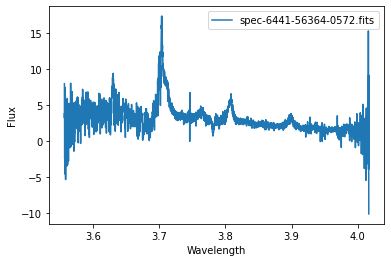

In [16]:
rnd_idx = np.random.randint(dataset.shape[0])
plate, mjd, fiberid = dataset.iloc[rnd_idx][["PLATE", "MJD", "FIBERID"]]
filename = "spec-{:04d}-{}-{:04d}.fits".format(plate, mjd, fiberid)
filepath = "data/DR16Q_Superset_v3/{:04d}/".format(plate) + filename
with fits.open(filepath) as hdul:
    data = hdul[1].data
    loglam = data["loglam"]
    flux = data["flux"]

fig, ax = plt.subplots()
ax.plot(loglam, flux, label=filename)
ax.set_xlabel("Wavelength")
ax.set_ylabel("Flux")
ax.legend();

In [17]:
loglam_idx = (loglammin <= loglam) & (loglam <= loglammax)
n_pixels = lam_idx.sum()
n_pixels

540007

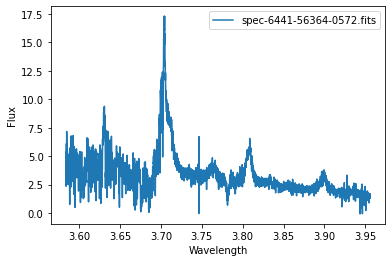

In [18]:
fig, ax = plt.subplots()
ax.plot(loglam[loglam_idx], flux[loglam_idx], label=filename)
ax.set_xlabel("Wavelength")
ax.set_ylabel("Flux")
ax.legend();

In [19]:
N_FEATURES = 512
EPS = 0.0005
new_loglam = np.linspace(loglammin + EPS, loglammax - EPS, N_FEATURES)
new_flux = minmax_scale(
    spectres(new_loglam, loglam[loglam_idx], flux[loglam_idx], verbose=True).astype(np.float32, copy=False).reshape(1, -1),
    feature_range=(-1, 1), axis=1, copy=False
)

In [20]:
new_loglam.shape, new_flux.shape

((512,), (1, 512))

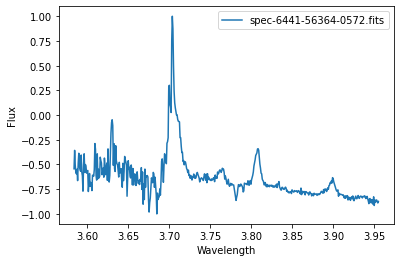

In [21]:
fig, ax = plt.subplots()
ax.plot(new_loglam, new_flux[0], label=filename)
ax.set_xlabel("Wavelength")
ax.set_ylabel("Flux")
ax.legend();

TODO: continuum normalisation?

## Save Data to a HDF5 File

In [22]:
ID_DTYPE = [("plate", np.int), ("mjd", np.int), ("fiberid", np.int)]

with h5py.File("data/dataset.hdf5", "x") as datafile:
    ids = np.zeros(len(dataset["PLATE"]), dtype=ID_DTYPE)
    ids["plate"], ids["mjd"], ids["fiberid"] = dataset["PLATE"], dataset["MJD"], dataset["FIBERID"]
    ids_dset = datafile.create_dataset("id", data=ids)
    z_dset   = datafile.create_dataset("z", data=dataset["Z"])